# Section 3

Rerun this notebook so that it saves images as pdfs

## Import libraries and define functions

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from warnings import simplefilter
#simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

from sklearn.model_selection import train_test_split

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#from sage.all import primes_first_n
import torch
import torch.nn as nn
import torch.optim as optim

#from sage.all import is_prime
from utils import build_ap_df
import gc
import pickle
import ast
import math
import random

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [27]:
def is_prime(n):
    if n < 2:
        return False
    # Check divisibility up to the square root of n
    for i in np.arange(2, int(np.sqrt(n)) + 1):
        if n % i == 0:
            return False
    return True
    
NUM_ANS = 1000
PRIME_COLUMNS = [str(n+1) for n in range(NUM_ANS) if is_prime(n+1)]

In [28]:
def calculate_accuracy(y_true, y_pred):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).sum().item()
    accuracy = correct / y_true.size(0)
    return accuracy

In [29]:
#seed = 11167297796775735125  # Set your desired seed value
random.seed(seed)

# Numpy
np.random.seed(seed)

# PyTorch
torch.manual_seed(seed)

# If you're using CUDA (GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups
    
    # Additional settings for reproducibility on GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## CNN on PRAT dataset

In [30]:
DF = pd.read_table('lfun_rat_ap.txt',delimiter=":",header='infer', low_memory=False)

In [31]:
DF = DF[(DF['primitive'] == True)&(DF['motivic_weight']==1) & (DF['degree']==4) & (DF['order_of_vanishing']<=3)]

In [32]:
DF_ap = build_ap_df(DF)
del DF
gc.collect()

30671

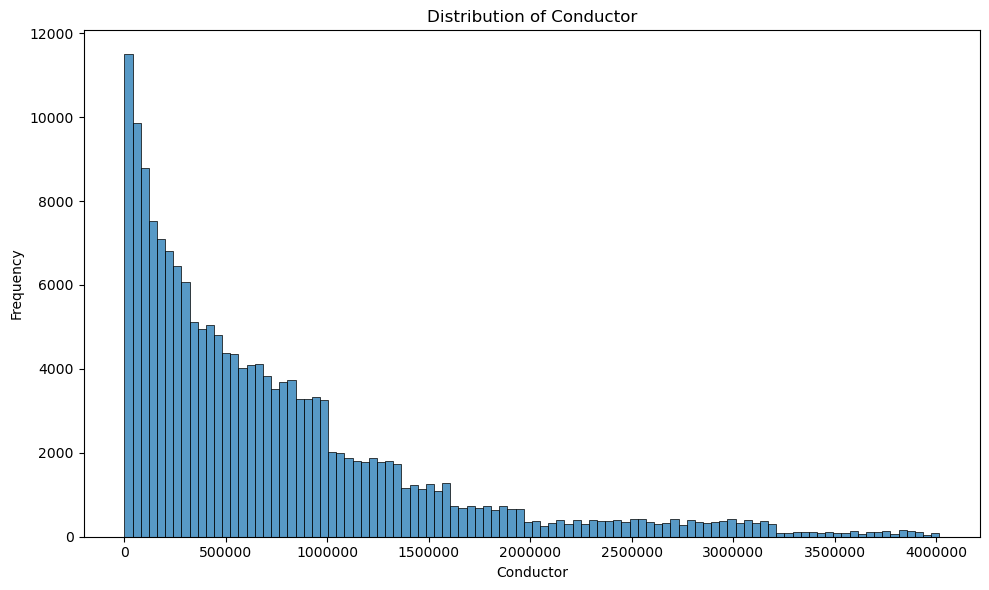

In [33]:
from matplotlib.ticker import ScalarFormatter
conductors = DF_ap['conductor'].to_numpy().astype(int)

plt.figure(figsize=(10, 6))

# Create a histogram with 20 bins
sns.histplot(conductors, bins=100)

plt.title('Distribution of Conductor')
plt.xlabel('Conductor')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().xaxis.get_major_formatter().set_scientific(False)
plt.tight_layout()
plt.show()

In [34]:
from collections import Counter

def compute_instance_type_stats(dataframe, column_name, instance_types):
    # Flatten the lists in the column and create a Counter
    flattened = [item for sublist in dataframe[column_name].apply(ast.literal_eval) for item in list(set(sublist))]
    counts = Counter(flattened)

    # Print the count for each instance type
    for instance in instance_types:
        print(f"{instance}: {counts.get(instance, 0)}")

#possible_instance_types = ['CMF', 'ECQ', 'Artin', 'ECNF', 'BMF', 'HMF', 'DIR', 'G2Q']
possible_instance_types = ['ECNF', 'BMF', 'HMF', 'G2Q']

# Compute the statistics
compute_instance_type_stats(DF_ap, 'instance_types', possible_instance_types)

ECNF: 113489
BMF: 81803
HMF: 31964
G2Q: 62780


In [35]:
DF_train, DF_test = train_test_split(DF_ap, test_size=0.2, random_state=0)

In [36]:
compute_instance_type_stats(DF_train, 'instance_types', possible_instance_types)

ECNF: 90714
BMF: 65385
HMF: 25550
G2Q: 50297


In [37]:
# Check if test set is evenly distributed
compute_instance_type_stats(DF_test, 'instance_types', possible_instance_types)

ECNF: 22775
BMF: 16418
HMF: 6414
G2Q: 12483


In [38]:
# The lists of indices in the test set for each type
type_indices = {
    instance_type: DF_test['instance_types'].apply(ast.literal_eval).apply(lambda x: instance_type in x).values
    for instance_type in possible_instance_types
}

In [45]:
batch_size = 3000
feature_columns = PRIME_COLUMNS[:168]
#feature_columns = PRIME_COLUMNS[:30]
# Extract feature columns and label
X_train = DF_train[feature_columns].values  # feature_columns are your input features
y_train = DF_train['order_of_vanishing'].values  # This is your label
X_test = DF_test[feature_columns].values  # feature_columns are your input features
y_test = DF_test['order_of_vanishing'].values  # This is your label

#del DF_train, DF_test, DF_ap
#gc.collect()

# Scale the data (optional but recommended for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for CNN (batch_size, channels, sequence_length)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # 1 channel
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])  # 1 channel

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [46]:
max_epochs = 25
saliency_value_list = []
test_accuracy_list = []

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  # Larger kernel size
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=1)

        # Dummy input to calculate flattened_size
        dummy_input = torch.zeros(1, 1, X_train.shape[-1])  # Example input size (batch_size, channels, length)
        self.flattened_size = self._get_flattened_size(dummy_input)

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_classes)  # Final output layer for classification

        self.dropout = nn.Dropout(0.5)

    def _get_flattened_size(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First conv layer + pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Second conv layer + pooling
        x = self.pool(torch.relu(self.conv3(x)))  # Third conv layer + pooling           
        return x.view(1, -1).size(1)  # Flatten and get size
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First conv layer + pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Second conv layer + pooling
        x = self.pool(torch.relu(self.conv3(x)))  # Third conv layer + pooling

        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc1(x))  # Fully connected layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer
        return x

# Initialize model, loss function, and optimizer
num_classes = len(set(y_test.numpy()))
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store accuracy values
train_accuracies = []
test_accuracies = []
test_accuracies_type = {instance_type : [] for instance_type in possible_instance_types}

model.eval()
with torch.no_grad():
    
    # Test accuracies for different types
    for instance_type in possible_instance_types:
        test_outputs = model(X_test[type_indices[instance_type]].to(device))
        test_accuracy = calculate_accuracy(y_test[type_indices[instance_type]].to(device), test_outputs)
        test_accuracies_type[instance_type].append(test_accuracy) 
        
# Training the model
epochs = max_epochs
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    with torch.no_grad():
        # Train accuracy
        #train_outputs = model(X_train)
        #train_accuracy = calculate_accuracy(y_train, train_outputs)
        train_accuracy = calculate_accuracy(labels, outputs)
        train_accuracies.append(train_accuracy)

        # Test accuracy
        test_outputs = model(X_test.to(device))
        test_accuracy = calculate_accuracy(y_test.to(device), test_outputs)
        test_accuracies.append(test_accuracy)

        # Test accuracies for different types
        for instance_type in possible_instance_types:
            test_outputs = model(X_test[type_indices[instance_type]].to(device))
            test_accuracy = calculate_accuracy(y_test[type_indices[instance_type]].to(device), test_outputs)
            test_accuracies_type[instance_type].append(test_accuracy) 

    # Print every 10 epochs
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

test_accuracy_list.append(test_accuracies)
#torch.save(model.state_dict(), f'Conductor_models/CNN_{conductor_min}_to_{conductor_min}.pth')

    
# Saliency Map Calculation
model.eval()  # Set the model to evaluation mode

# Get a single sample from the test set for saliency calculation
input_data = X_test[torch.randperm(X_test.size(0))[:3000]].clone().detach().requires_grad_(True)

# Forward pass
output = model(input_data.to(device))
_, predicted_class = torch.max(output, 1)  # Get the predicted class index

model.zero_grad()

# Create a one-hot encoding of the predicted classes (this is a binary mask)
one_hot = torch.zeros_like(output)
one_hot[torch.arange(output.size(0)), predicted_class] = 1

# Perform a single backward pass for the entire batch
output.backward(gradient=one_hot, retain_graph=True)

# The gradients for input_data will now be populated for the entire batch
saliency = input_data.grad  # Saliency map for each sample
    
# Average the saliency across the training set
saliency = saliency.abs().mean(dim=0).squeeze().detach().cpu().numpy()

saliency_value_list.append(saliency)

Epoch [1/25], Loss: 0.8895, Train Accuracy: 0.8950, Test Accuracy: 0.8621
Epoch [2/25], Loss: 0.2659, Train Accuracy: 0.9138, Test Accuracy: 0.9192
Epoch [3/25], Loss: 0.1951, Train Accuracy: 0.9360, Test Accuracy: 0.9515
Epoch [4/25], Loss: 0.1722, Train Accuracy: 0.9398, Test Accuracy: 0.9567
Epoch [5/25], Loss: 0.1571, Train Accuracy: 0.9470, Test Accuracy: 0.9593
Epoch [6/25], Loss: 0.1441, Train Accuracy: 0.9453, Test Accuracy: 0.9647
Epoch [7/25], Loss: 0.1374, Train Accuracy: 0.9531, Test Accuracy: 0.9680
Epoch [8/25], Loss: 0.1308, Train Accuracy: 0.9487, Test Accuracy: 0.9703
Epoch [9/25], Loss: 0.1269, Train Accuracy: 0.9559, Test Accuracy: 0.9725
Epoch [10/25], Loss: 0.1238, Train Accuracy: 0.9603, Test Accuracy: 0.9684
Epoch [11/25], Loss: 0.1228, Train Accuracy: 0.9596, Test Accuracy: 0.9735
Epoch [12/25], Loss: 0.1195, Train Accuracy: 0.9525, Test Accuracy: 0.9724
Epoch [13/25], Loss: 0.1196, Train Accuracy: 0.9525, Test Accuracy: 0.9736
Epoch [14/25], Loss: 0.1155, Train

In [47]:
saliency_type_dict = dict.fromkeys(possible_instance_types, None)
for instance_type in possible_instance_types:

    # Get a single sample from the test set for saliency calculation
    X_test_type = X_test[type_indices[instance_type]]
    input_data = X_test_type[torch.randperm(X_test_type.size(0))[:3000]].clone().detach().requires_grad_(True)
    
    # Forward pass
    output = model(input_data.to(device))
    _, predicted_class = torch.max(output, 1)  # Get the predicted class index
    
    model.zero_grad()
    
    # Create a one-hot encoding of the predicted classes (this is a binary mask)
    one_hot = torch.zeros_like(output)
    one_hot[torch.arange(output.size(0)), predicted_class] = 1
    
    # Perform a single backward pass for the entire batch
    output.backward(gradient=one_hot, retain_graph=True)
    
    # The gradients for input_data will now be populated for the entire batch
    saliency = input_data.grad  # Saliency map for each sample
        
    # Average the saliency across the training set
    saliency = saliency.abs().mean(dim=0).squeeze().detach().cpu().numpy()
    
    saliency_type_dict[instance_type] = saliency

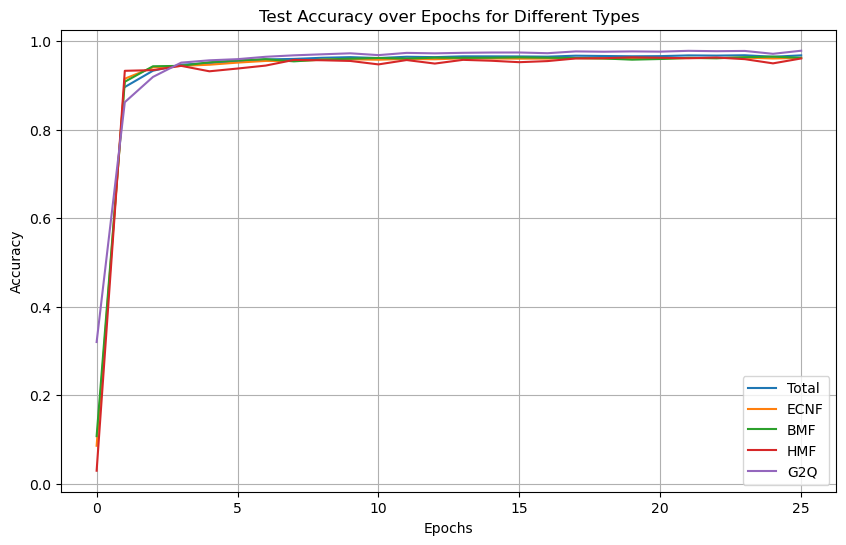

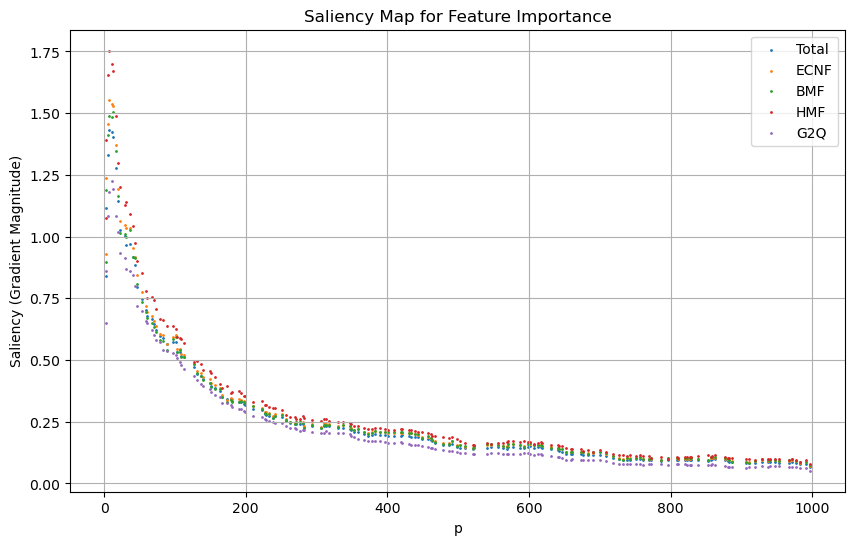

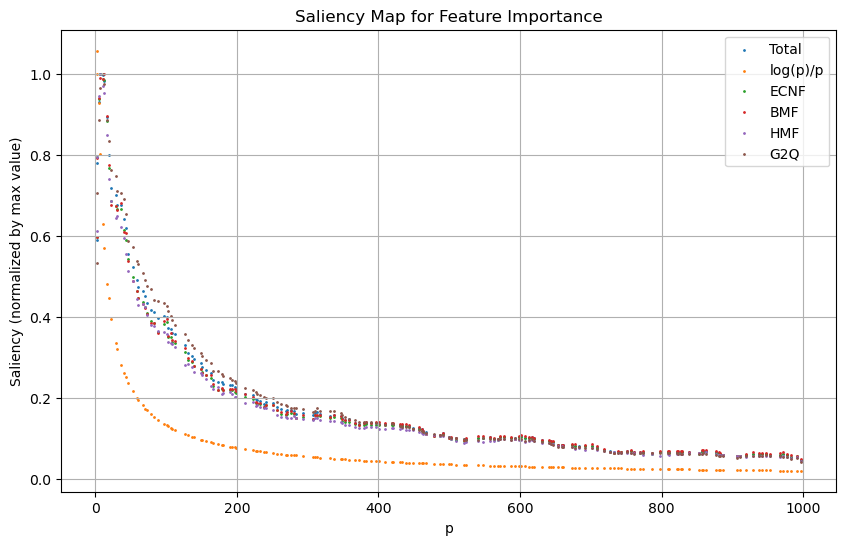

In [48]:
# Plotting train and test accuracy
plt.figure(figsize=(10, 6))
i = 0
plt.plot(range(1, epochs+1), test_accuracy_list[i], label='Total')
for instance_type in possible_instance_types:
    plt.plot(range(0, epochs+1), test_accuracies_type[instance_type], label=f'{instance_type}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs for Different Types')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve_aps.pdf')
plt.show()

plt.figure(figsize=(10, 6))
prime_numbers = [float(num) for num in feature_columns]
i = 0   
plt.scatter(prime_numbers, saliency_value_list[i], label='Total', s=1)
for instance_type in possible_instance_types:
    plt.scatter(prime_numbers, saliency_type_dict[instance_type], label=f'{instance_type}', s=1)
#plt.scatter(prime_numbers, np.log(prime_numbers) / prime_numbers / (np.log(10000)), label='log(p)/p', s=1)
plt.title('Saliency Map for Feature Importance')
plt.ylabel('Saliency (Gradient Magnitude)')  # Label for x-axis
plt.xlabel('p')  # Label for y-axis
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
prime_numbers = [float(num) for num in feature_columns]
i = 0
plt.scatter(prime_numbers, saliency_value_list[i]/np.max(saliency_value_list[i]), label='Total', s=1)
plt.scatter(prime_numbers, np.log(prime_numbers) / prime_numbers / (np.log(2)/2), label='log(p)/p', s=1)
for instance_type in possible_instance_types:
    plt.scatter(prime_numbers, saliency_type_dict[instance_type]/np.max(saliency_type_dict[instance_type]), 
                label=f'{instance_type}', s=1)
plt.title('Saliency Map for Feature Importance')
plt.ylabel('Saliency (normalized by max value)')  # Label for x-axis
plt.xlabel('p')  # Label for y-axis
plt.legend()
plt.grid(True)
plt.show()

In [49]:
for instance_type in possible_instance_types:
    print(instance_type, f'{test_accuracies_type[instance_type][-1]:.4f}')

ECNF 0.9620
BMF 0.9624
HMF 0.9609
G2Q 0.9784


### Transfer learning between ECNF and G2Q

In [58]:
random.seed(seed)

# Numpy
np.random.seed(seed)

# PyTorch
torch.manual_seed(seed)

# If you're using CUDA (GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups
    
    # Additional settings for reproducibility on GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#### G2Q

In [59]:
DF_G2Q = DF_ap[DF_ap['instance_types'].apply(ast.literal_eval).apply(lambda x: 'G2Q' in x).values]
DF_no_G2Q = DF_ap[~DF_ap['instance_types'].apply(ast.literal_eval).apply(lambda x: 'G2Q' in x).values]
DF_train, _ = train_test_split(DF_no_G2Q, test_size=0.2, random_state=0)
_, DF_test = train_test_split(DF_G2Q, test_size=0.9, random_state=0)

In [60]:
batch_size = 4000
feature_columns = PRIME_COLUMNS[:168]

# Extract feature columns and label
X_train = DF_train[feature_columns].values  # feature_columns are your input features
y_train = DF_train['order_of_vanishing'].values  # This is your label
X_test = DF_test[feature_columns].values  # feature_columns are your input features
y_test = DF_test['order_of_vanishing'].values  # This is your label

#del DF_train, DF_test, DF_ap
#gc.collect()

# Scale the data (optional but recommended for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for CNN (batch_size, channels, sequence_length)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # 1 channel
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])  # 1 channel

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [61]:
max_epochs = 25
saliency_value_list = []
test_accuracy_list = []

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  # Larger kernel size
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=1)

        # Dummy input to calculate flattened_size
        dummy_input = torch.zeros(1, 1, X_train.shape[-1])  # Example input size (batch_size, channels, length)
        self.flattened_size = self._get_flattened_size(dummy_input)

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_classes)  # Final output layer for classification

        self.dropout = nn.Dropout(0.5)

    def _get_flattened_size(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First conv layer + pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Second conv layer + pooling
        x = self.pool(torch.relu(self.conv3(x)))  # Third conv layer + pooling           
        return x.view(1, -1).size(1)  # Flatten and get size
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First conv layer + pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Second conv layer + pooling
        x = self.pool(torch.relu(self.conv3(x)))  # Third conv layer + pooling

        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc1(x))  # Fully connected layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer
        return x

# Initialize model, loss function, and optimizer
num_classes = 5
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store accuracy values
train_accuracies = []
test_accuracies = []

model.eval()
with torch.no_grad():  
    test_outputs = model(X_test.to(device))
    test_accuracy = calculate_accuracy(y_test.to(device), test_outputs)
    test_accuracies.append(test_accuracy)
    
# Training the model
epochs = max_epochs
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    step = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if epoch == 0 and step == 0:
            model.eval()
            with torch.no_grad():
                train_accuracy = calculate_accuracy(labels, outputs)
                train_accuracies.append(train_accuracy)
            model.train()
        step += 1

    model.eval()
    with torch.no_grad():
        # Train accuracy
        #train_outputs = model(X_train)
        #train_accuracy = calculate_accuracy(y_train, train_outputs)
        train_accuracy = calculate_accuracy(labels, outputs)
        train_accuracies.append(train_accuracy)

        # Test accuracy
        test_outputs = model(X_test.to(device))
        test_accuracy = calculate_accuracy(y_test.to(device), test_outputs)
        test_accuracies.append(test_accuracy)

    # Print every 10 epochs
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

test_accuracy_list.append(test_accuracies)
#torch.save(model.state_dict(), f'Conductor_models/CNN_{conductor_min}_to_{conductor_min}.pth')

    
# Saliency Map Calculation
model.eval()  # Set the model to evaluation mode

# Get a single sample from the test set for saliency calculation
input_data = X_test[torch.randperm(X_test.size(0))[:3000]].clone().detach().requires_grad_(True)

# Forward pass
output = model(input_data.to(device))
_, predicted_class = torch.max(output, 1)  # Get the predicted class index

model.zero_grad()

# Create a one-hot encoding of the predicted classes (this is a binary mask)
one_hot = torch.zeros_like(output)
one_hot[torch.arange(output.size(0)), predicted_class] = 1

# Perform a single backward pass for the entire batch
output.backward(gradient=one_hot, retain_graph=True)

# The gradients for input_data will now be populated for the entire batch
saliency = input_data.grad  # Saliency map for each sample
    
# Average the saliency across the training set
saliency = saliency.abs().mean(dim=0).squeeze().detach().cpu().numpy()

saliency_value_list.append(saliency)

Epoch [1/25], Loss: 1.0668, Train Accuracy: 0.6511, Test Accuracy: 0.5197
Epoch [2/25], Loss: 0.6462, Train Accuracy: 0.8381, Test Accuracy: 0.5958
Epoch [3/25], Loss: 0.3268, Train Accuracy: 0.9096, Test Accuracy: 0.8384
Epoch [4/25], Loss: 0.2183, Train Accuracy: 0.9241, Test Accuracy: 0.8891
Epoch [5/25], Loss: 0.1860, Train Accuracy: 0.9385, Test Accuracy: 0.8977
Epoch [6/25], Loss: 0.1693, Train Accuracy: 0.9367, Test Accuracy: 0.8938
Epoch [7/25], Loss: 0.1589, Train Accuracy: 0.9470, Test Accuracy: 0.8988
Epoch [8/25], Loss: 0.1536, Train Accuracy: 0.9467, Test Accuracy: 0.9034
Epoch [9/25], Loss: 0.1487, Train Accuracy: 0.9426, Test Accuracy: 0.9038
Epoch [10/25], Loss: 0.1483, Train Accuracy: 0.9433, Test Accuracy: 0.9027
Epoch [11/25], Loss: 0.1449, Train Accuracy: 0.9519, Test Accuracy: 0.9017
Epoch [12/25], Loss: 0.1409, Train Accuracy: 0.9548, Test Accuracy: 0.9067
Epoch [13/25], Loss: 0.1398, Train Accuracy: 0.9459, Test Accuracy: 0.9094
Epoch [14/25], Loss: 0.1344, Train

23 steps per epoch


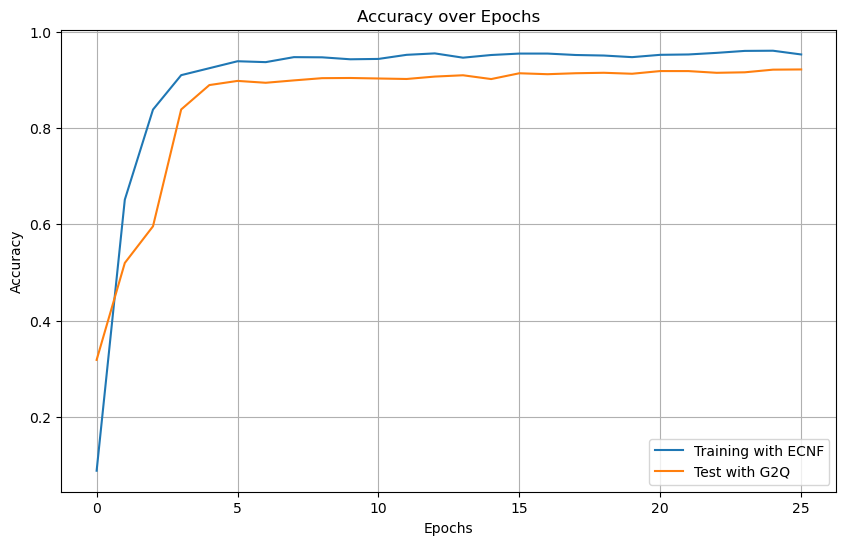

In [62]:
step_per_epoch = math.ceil(len(X_train) / batch_size)
print(f'{step_per_epoch} steps per epoch')
plt.figure(figsize=(10, 6))
i = 0
plt.plot(range(0, epochs+1) , train_accuracies, label='Training with ECNF')
plt.plot(range(0, epochs+1) , test_accuracy_list[i], label='Test with G2Q')
#plt.plot([epoch*step_per_epoch/10 for epoch in range(1, epochs+1)] , test_accuracy_list[i], label='ECQ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('ECNF_to_G2Q.pdf')
plt.show()

#### ECNF

In [63]:
DF_ECNF = DF_ap[DF_ap['instance_types'].apply(ast.literal_eval).apply(lambda x: 'ECNF' in x).values]
DF_no_ECNF = DF_ap[~DF_ap['instance_types'].apply(ast.literal_eval).apply(lambda x: 'ECNF' in x).values]
DF_train, _ = train_test_split(DF_no_ECNF, test_size=0.2, random_state=0)
_, DF_test = train_test_split(DF_ECNF, test_size=0.4, random_state=0)

In [64]:
batch_size = 3000
feature_columns = PRIME_COLUMNS[:168]

# Extract feature columns and label
X_train = DF_train[feature_columns].values  # feature_columns are your input features
y_train = DF_train['order_of_vanishing'].values  # This is your label
X_test = DF_test[feature_columns].values  # feature_columns are your input features
y_test = DF_test['order_of_vanishing'].values  # This is your label

#del DF_train, DF_test, DF_ap
#gc.collect()

# Scale the data (optional but recommended for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for CNN (batch_size, channels, sequence_length)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # 1 channel
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])  # 1 channel

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [65]:
max_epochs = 25
saliency_value_list = []
test_accuracy_list = []

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  # Larger kernel size
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=1)

        # Dummy input to calculate flattened_size
        dummy_input = torch.zeros(1, 1, X_train.shape[-1])  # Example input size (batch_size, channels, length)
        self.flattened_size = self._get_flattened_size(dummy_input)

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_classes)  # Final output layer for classification

        self.dropout = nn.Dropout(0.5)

    def _get_flattened_size(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First conv layer + pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Second conv layer + pooling
        x = self.pool(torch.relu(self.conv3(x)))  # Third conv layer + pooling           
        return x.view(1, -1).size(1)  # Flatten and get size
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First conv layer + pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Second conv layer + pooling
        x = self.pool(torch.relu(self.conv3(x)))  # Third conv layer + pooling

        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc1(x))  # Fully connected layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer
        return x

# Initialize model, loss function, and optimizer
num_classes = 5
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store accuracy values
train_accuracies = []
test_accuracies = []

model.eval()
with torch.no_grad():  
    test_outputs = model(X_test.to(device))
    test_accuracy = calculate_accuracy(y_test.to(device), test_outputs)
    test_accuracies.append(test_accuracy)
    
# Training the model
epochs = max_epochs
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    step = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if epoch == 0 and step == 0:
            model.eval()
            with torch.no_grad():
                train_accuracy = calculate_accuracy(labels, outputs)
                train_accuracies.append(train_accuracy)
            model.train()
        step += 1

    model.eval()
    with torch.no_grad():
        # Train accuracy
        #train_outputs = model(X_train)
        #train_accuracy = calculate_accuracy(y_train, train_outputs)
        train_accuracy = calculate_accuracy(labels, outputs)
        train_accuracies.append(train_accuracy)

        # Test accuracy
        test_outputs = model(X_test.to(device))
        test_accuracy = calculate_accuracy(y_test.to(device), test_outputs)
        test_accuracies.append(test_accuracy)

    # Print every 10 epochs
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

test_accuracy_list.append(test_accuracies)
#torch.save(model.state_dict(), f'Conductor_models/CNN_{conductor_min}_to_{conductor_min}.pth')

    
# Saliency Map Calculation
model.eval()  # Set the model to evaluation mode

# Get a single sample from the test set for saliency calculation
input_data = X_test[torch.randperm(X_test.size(0))[:3000]].clone().detach().requires_grad_(True)

# Forward pass
output = model(input_data.to(device))
_, predicted_class = torch.max(output, 1)  # Get the predicted class index

model.zero_grad()

# Create a one-hot encoding of the predicted classes (this is a binary mask)
one_hot = torch.zeros_like(output)
one_hot[torch.arange(output.size(0)), predicted_class] = 1

# Perform a single backward pass for the entire batch
output.backward(gradient=one_hot, retain_graph=True)

# The gradients for input_data will now be populated for the entire batch
saliency = input_data.grad  # Saliency map for each sample
    
# Average the saliency across the training set
saliency = saliency.abs().mean(dim=0).squeeze().detach().cpu().numpy()

saliency_value_list.append(saliency)

Epoch [1/25], Loss: 1.2915, Train Accuracy: 0.4655, Test Accuracy: 0.5387
Epoch [2/25], Loss: 1.0958, Train Accuracy: 0.6835, Test Accuracy: 0.5547
Epoch [3/25], Loss: 0.6983, Train Accuracy: 0.8214, Test Accuracy: 0.8295
Epoch [4/25], Loss: 0.3875, Train Accuracy: 0.8645, Test Accuracy: 0.8931
Epoch [5/25], Loss: 0.2655, Train Accuracy: 0.9114, Test Accuracy: 0.8894
Epoch [6/25], Loss: 0.2062, Train Accuracy: 0.9241, Test Accuracy: 0.9103
Epoch [7/25], Loss: 0.1732, Train Accuracy: 0.9358, Test Accuracy: 0.9227
Epoch [8/25], Loss: 0.1565, Train Accuracy: 0.9400, Test Accuracy: 0.9350
Epoch [9/25], Loss: 0.1471, Train Accuracy: 0.9498, Test Accuracy: 0.9115
Epoch [10/25], Loss: 0.1424, Train Accuracy: 0.9494, Test Accuracy: 0.9357
Epoch [11/25], Loss: 0.1315, Train Accuracy: 0.9597, Test Accuracy: 0.9264
Epoch [12/25], Loss: 0.1259, Train Accuracy: 0.9512, Test Accuracy: 0.9273
Epoch [13/25], Loss: 0.1280, Train Accuracy: 0.9498, Test Accuracy: 0.9308
Epoch [14/25], Loss: 0.1212, Train

17 steps per epoch


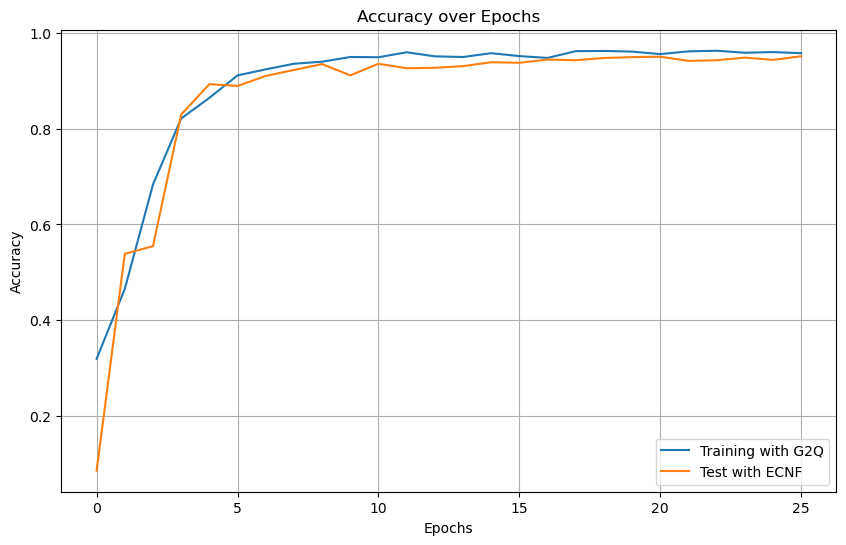

In [66]:
step_per_epoch = math.ceil(len(X_train) / batch_size)
print(f'{step_per_epoch} steps per epoch')
plt.figure(figsize=(10, 6))
i = 0
plt.plot(range(0, epochs+1) , train_accuracies, label='Training with G2Q')
plt.plot(range(0, epochs+1) , test_accuracy_list[i], label='Test with ECNF')
#plt.plot([epoch*step_per_epoch/10 for epoch in range(1, epochs+1)] , test_accuracy_list[i], label='ECQ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('G2Q_to_ECNF.pdf')
plt.show()

## Train with principal components

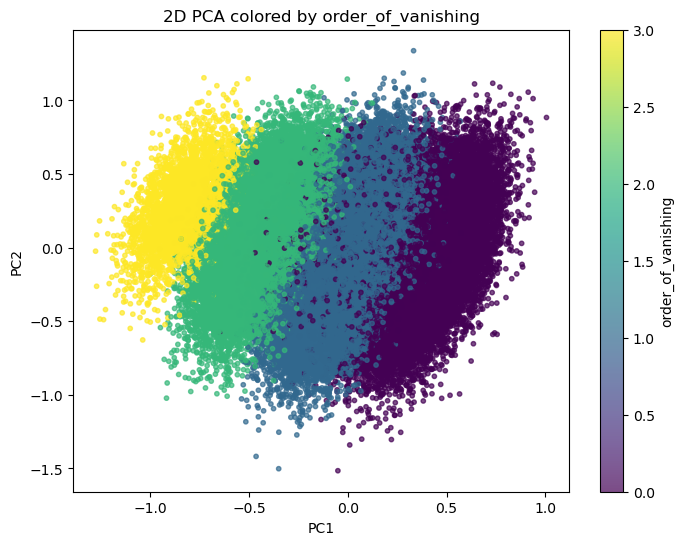

In [67]:
DF_PCA = DF_ap
feature_columns = PRIME_COLUMNS

X = DF_PCA[feature_columns]
y = DF_PCA['label']
pca = PCA(n_components=168)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#principal_components = pca.fit(X)
principal_components = pca.fit_transform(X)
#principal_components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(len(feature_columns))])
pca_df['label'] = y.values

col = 'order_of_vanishing'
vals = DF_PCA[col].value_counts()

color = DF_PCA[col]

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=color, alpha=0.7, s=10, cmap='viridis')

# Add labels and title
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f'2D PCA colored by {col}')

# Add color bar
plt.colorbar(label=col)

# Show the plot
plt.show()

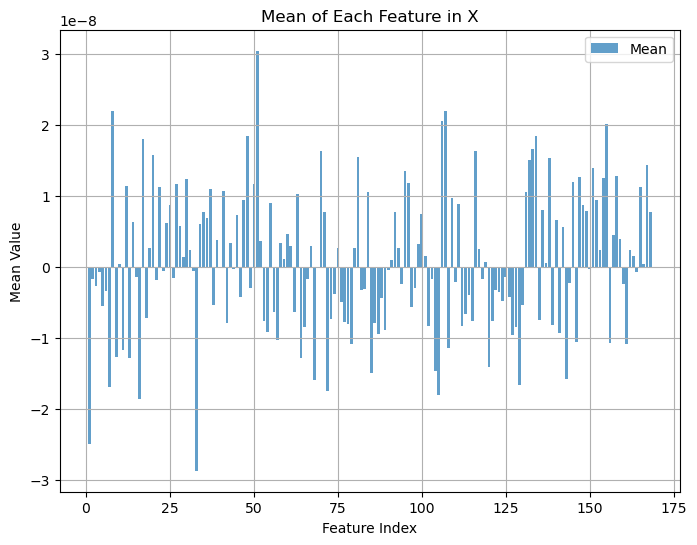

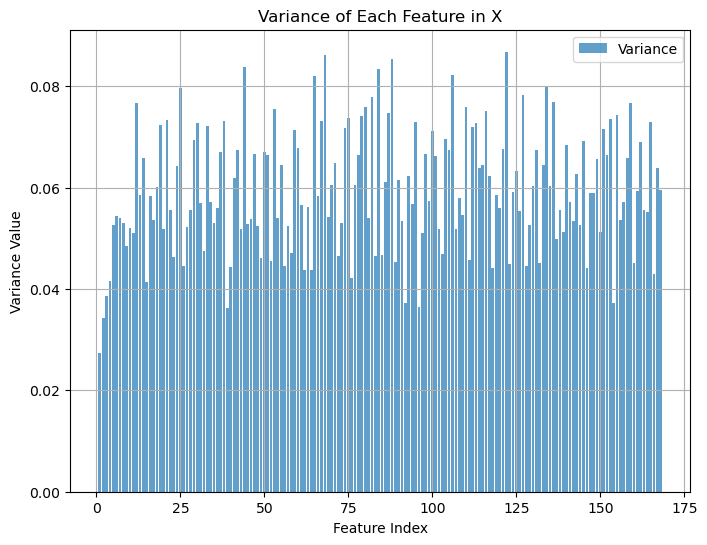

In [68]:
mean_values = np.mean(X_scaled, axis=0)
variance_values = np.var(X, axis=0)

# Plot mean values
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(mean_values) + 1), mean_values, alpha=0.7, label='Mean')
plt.xlabel('Feature Index')
plt.ylabel('Mean Value')
plt.title('Mean of Each Feature in X')
plt.legend()
plt.grid(True)
plt.show()

# Plot variance values
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(variance_values) + 1), variance_values, alpha=0.7, label='Variance')
plt.xlabel('Feature Index')
plt.ylabel('Variance Value')
plt.title('Variance of Each Feature in X')
plt.legend()
plt.grid(True)
plt.show()

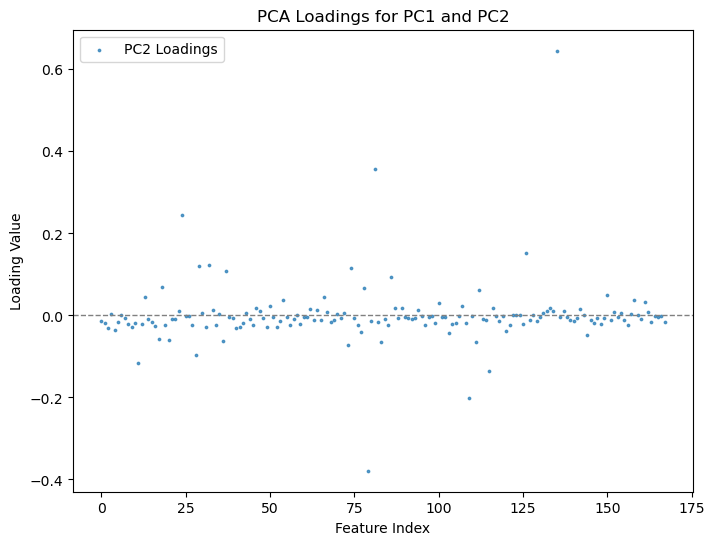

In [69]:
loadings = pca.components_

# Extract PC1 and PC2 weights
#pc1_loadings = loadings[0]
pc2_loadings = loadings[15]
#pc3_loadings = loadings[2]

# Feature indices for plotting
feature_indices = np.arange(168)

# Plot PC1 weights
plt.figure(figsize=(8, 6))
#plt.scatter(feature_indices, pc1_loadings, alpha=0.7, label="PC1 Loadings",s=3)
plt.scatter(feature_indices, pc2_loadings, alpha=0.7, label="PC2 Loadings", s=3)
#plt.scatter(feature_indices, pc3_loadings, alpha=0.7, label="PC3 Loadings", s=2)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Feature Index")
plt.ylabel("Loading Value")
plt.title("PCA Loadings for PC1 and PC2")
plt.legend()
plt.show()

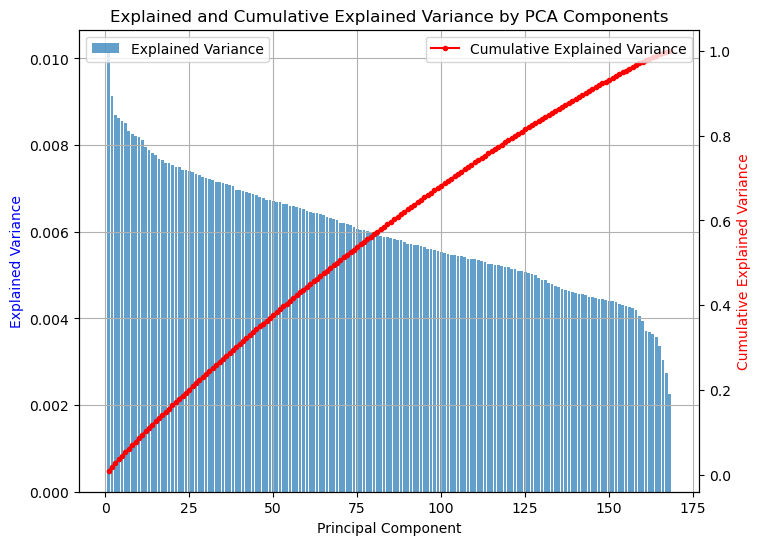

In [70]:
# Compute explained variance and cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance and cumulative explained variance with different scales
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
ax1.bar(range(1, 169), explained_variance, alpha=0.7, label='Explained Variance')
ax2.plot(range(1, 169), cumulative_variance, marker='.', linestyle='-', color='r', label='Cumulative Explained Variance')

ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance', color='b')
ax2.set_ylabel('Cumulative Explained Variance', color='r')
ax1.set_title('Explained and Cumulative Explained Variance by PCA Components')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)
plt.show()


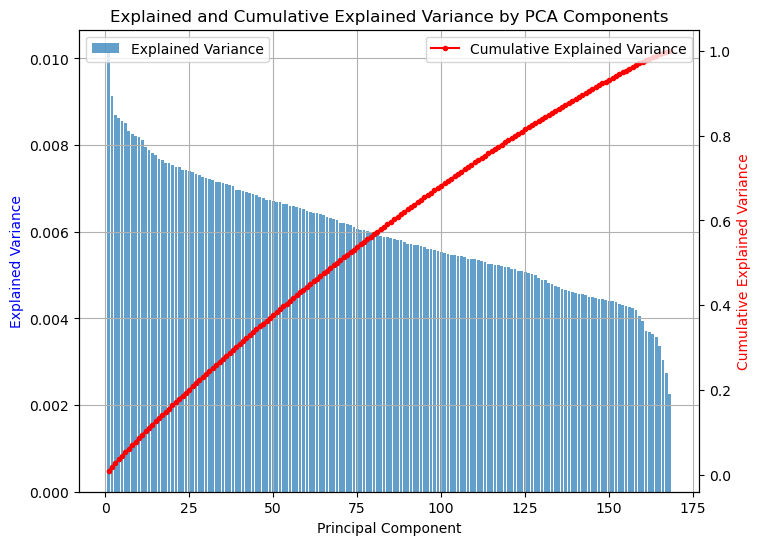

In [71]:
# Compute explained variance and cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance and cumulative explained variance with different scales
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
ax1.bar(range(1, 169), explained_variance, alpha=0.7, label='Explained Variance')
ax2.plot(range(1, 169), cumulative_variance, marker='.', linestyle='-', color='r', label='Cumulative Explained Variance')

ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance', color='b')
ax2.set_ylabel('Cumulative Explained Variance', color='r')
ax1.set_title('Explained and Cumulative Explained Variance by PCA Components')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)
plt.show()


In [72]:
pca_df = pca_df.merge(DF_PCA[['label', 'instance_types', 'order_of_vanishing']], on='label', how='left')

In [73]:
DF_train, DF_test = train_test_split(pca_df, test_size=0.2, random_state=0)

In [74]:
batch_size = 3000
feature_columns = PRIME_COLUMNS[:168]
PC_columns = [f'PC{i+1}' for i in range(len(feature_columns))]

# Extract feature columns and label
X_train = DF_train[PC_columns].values  # feature_columns are your input features
y_train = DF_train['order_of_vanishing'].values  # This is your label
X_test = DF_test[PC_columns].values  # feature_columns are your input features
y_test = DF_test['order_of_vanishing'].values  # This is your label

#del DF_train, DF_test, DF_ap
#gc.collect()

# Scale the data (optional but recommended for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for CNN (batch_size, channels, sequence_length)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # 1 channel
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])  # 1 channel

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [75]:
max_epochs = 25
saliency_value_list = []
test_accuracy_list = []

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  # Larger kernel size
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=1)

        # Dummy input to calculate flattened_size
        dummy_input = torch.zeros(1, 1, X_train.shape[-1])  # Example input size (batch_size, channels, length)
        self.flattened_size = self._get_flattened_size(dummy_input)

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_classes)  # Final output layer for classification

        self.dropout = nn.Dropout(0.5)

    def _get_flattened_size(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First conv layer + pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Second conv layer + pooling
        x = self.pool(torch.relu(self.conv3(x)))  # Third conv layer + pooling           
        return x.view(1, -1).size(1)  # Flatten and get size
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First conv layer + pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Second conv layer + pooling
        x = self.pool(torch.relu(self.conv3(x)))  # Third conv layer + pooling

        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc1(x))  # Fully connected layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer
        return x

# Initialize model, loss function, and optimizer
num_classes = len(set(y_test.numpy()))
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store accuracy values
train_accuracies = []
test_accuracies = []
test_accuracies_type = {instance_type : [] for instance_type in possible_instance_types}

model.eval()
with torch.no_grad():
    
    # Test accuracies for different types
    for instance_type in possible_instance_types:
        test_outputs = model(X_test[type_indices[instance_type]].to(device))
        test_accuracy = calculate_accuracy(y_test[type_indices[instance_type]].to(device), test_outputs)
        test_accuracies_type[instance_type].append(test_accuracy) 
        
# Training the model
epochs = max_epochs
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    with torch.no_grad():
        # Train accuracy
        #train_outputs = model(X_train)
        #train_accuracy = calculate_accuracy(y_train, train_outputs)
        train_accuracy = calculate_accuracy(labels, outputs)
        train_accuracies.append(train_accuracy)

        # Test accuracy
        test_outputs = model(X_test.to(device))
        test_accuracy = calculate_accuracy(y_test.to(device), test_outputs)
        test_accuracies.append(test_accuracy)

        # Test accuracies for different types
        for instance_type in possible_instance_types:
            test_outputs = model(X_test[type_indices[instance_type]].to(device))
            test_accuracy = calculate_accuracy(y_test[type_indices[instance_type]].to(device), test_outputs)
            test_accuracies_type[instance_type].append(test_accuracy) 

    # Print every 10 epochs
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

test_accuracy_list.append(test_accuracies)
#torch.save(model.state_dict(), f'Conductor_models/CNN_{conductor_min}_to_{conductor_min}.pth')

    
# Saliency Map Calculation
model.eval()  # Set the model to evaluation mode

# Get a single sample from the test set for saliency calculation
input_data = X_test[torch.randperm(X_test.size(0))[:3000]].clone().detach().requires_grad_(True)

# Forward pass
output = model(input_data.to(device))
_, predicted_class = torch.max(output, 1)  # Get the predicted class index

model.zero_grad()

# Create a one-hot encoding of the predicted classes (this is a binary mask)
one_hot = torch.zeros_like(output)
one_hot[torch.arange(output.size(0)), predicted_class] = 1

# Perform a single backward pass for the entire batch
output.backward(gradient=one_hot, retain_graph=True)

# The gradients for input_data will now be populated for the entire batch
saliency = input_data.grad  # Saliency map for each sample
    
# Average the saliency across the training set
saliency = saliency.abs().mean(dim=0).squeeze().detach().cpu().numpy()

saliency_value_list.append(saliency)

Epoch [1/25], Loss: 1.0899, Train Accuracy: 0.5174, Test Accuracy: 0.4647
Epoch [2/25], Loss: 0.6016, Train Accuracy: 0.8806, Test Accuracy: 0.8787
Epoch [3/25], Loss: 0.2733, Train Accuracy: 0.9066, Test Accuracy: 0.9136
Epoch [4/25], Loss: 0.2313, Train Accuracy: 0.9155, Test Accuracy: 0.9275
Epoch [5/25], Loss: 0.2150, Train Accuracy: 0.9213, Test Accuracy: 0.9351
Epoch [6/25], Loss: 0.2020, Train Accuracy: 0.9261, Test Accuracy: 0.9371
Epoch [7/25], Loss: 0.1974, Train Accuracy: 0.9224, Test Accuracy: 0.9390
Epoch [8/25], Loss: 0.1892, Train Accuracy: 0.9343, Test Accuracy: 0.9411
Epoch [9/25], Loss: 0.1847, Train Accuracy: 0.9374, Test Accuracy: 0.9388
Epoch [10/25], Loss: 0.1815, Train Accuracy: 0.9313, Test Accuracy: 0.9406
Epoch [11/25], Loss: 0.1769, Train Accuracy: 0.9350, Test Accuracy: 0.9476
Epoch [12/25], Loss: 0.1734, Train Accuracy: 0.9282, Test Accuracy: 0.9457
Epoch [13/25], Loss: 0.1731, Train Accuracy: 0.9350, Test Accuracy: 0.9466
Epoch [14/25], Loss: 0.1672, Train

In [76]:
saliency_type_dict = dict.fromkeys(possible_instance_types, None)
for instance_type in possible_instance_types:

    # Get a single sample from the test set for saliency calculation
    X_test_type = X_test[type_indices[instance_type]]
    input_data = X_test_type[torch.randperm(X_test_type.size(0))[:3000]].clone().detach().requires_grad_(True)
    
    # Forward pass
    output = model(input_data.to(device))
    _, predicted_class = torch.max(output, 1)  # Get the predicted class index
    
    model.zero_grad()
    
    # Create a one-hot encoding of the predicted classes (this is a binary mask)
    one_hot = torch.zeros_like(output)
    one_hot[torch.arange(output.size(0)), predicted_class] = 1
    
    # Perform a single backward pass for the entire batch
    output.backward(gradient=one_hot, retain_graph=True)
    
    # The gradients for input_data will now be populated for the entire batch
    saliency = input_data.grad  # Saliency map for each sample
        
    # Average the saliency across the training set
    saliency = saliency.abs().mean(dim=0).squeeze().detach().cpu().numpy()
    
    saliency_type_dict[instance_type] = saliency

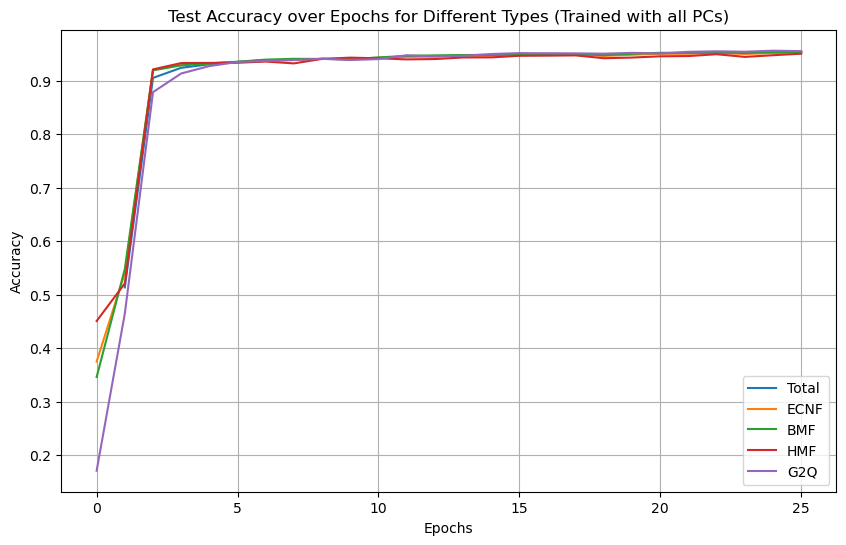

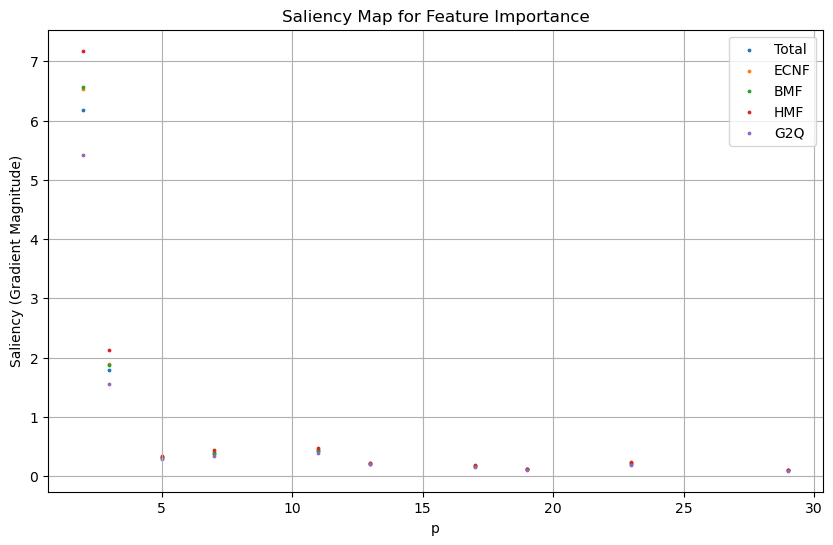

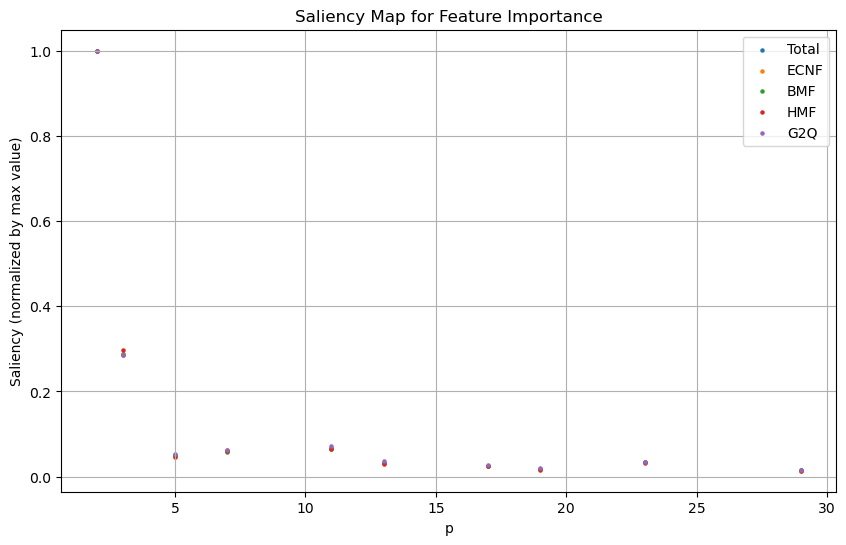

In [77]:
# Plotting train and test accuracy
plt.figure(figsize=(10, 6))
i = 0
plt.plot(range(1, epochs+1), test_accuracy_list[i], label='Total')
for instance_type in possible_instance_types:
    plt.plot(range(0, epochs+1), test_accuracies_type[instance_type], label=f'{instance_type}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs for Different Types (Trained with all PCs)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
prime_numbers = [float(num) for num in feature_columns]
i = 0   
plt.scatter(prime_numbers[:10], saliency_value_list[i][:10], label='Total', s=3)
for instance_type in possible_instance_types:
    plt.scatter(prime_numbers[:10], saliency_type_dict[instance_type][:10], label=f'{instance_type}', s=3)
#plt.scatter(prime_numbers, np.log(prime_numbers) / prime_numbers / (np.log(10000)), label='log(p)/p', s=1)
plt.title('Saliency Map for Feature Importance')
plt.ylabel('Saliency (Gradient Magnitude)')  # Label for x-axis
plt.xlabel('p')  # Label for y-axis
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
prime_numbers = [float(num) for num in feature_columns]
i = 0
plt.scatter(prime_numbers[:10], saliency_value_list[i][:10]/np.max(saliency_value_list[i][:10]), label='Total', s=5)
#plt.scatter(prime_numbers, np.log(prime_numbers) / prime_numbers / (np.log(2)/2), label='log(p)/p', s=1)
for instance_type in possible_instance_types:
    plt.scatter(prime_numbers[:10], saliency_type_dict[instance_type][:10]/np.max(saliency_type_dict[instance_type][:10]), 
                label=f'{instance_type}', s=5)
plt.title('Saliency Map for Feature Importance')
plt.ylabel('Saliency (normalized by max value)')  # Label for x-axis
plt.xlabel('p')  # Label for y-axis
plt.legend()
plt.grid(True)
plt.show()

In [78]:
for instance_type in possible_instance_types:
    print(instance_type, f'{test_accuracies_type[instance_type][-1]:.4f}')

ECNF 0.9529
BMF 0.9536
HMF 0.9506
G2Q 0.9555


### Trained with PC1 and PC2

In [79]:
batch_size = 3000
feature_columns = PRIME_COLUMNS[:2]
PC_columns = [f'PC{i+1}' for i in range(len(feature_columns))]
PC_columns = ['PC1','PC2']

# Extract feature columns and label
X_train = DF_train[PC_columns].values  # feature_columns are your input features
y_train = DF_train['order_of_vanishing'].values  # This is your label
X_test = DF_test[PC_columns].values  # feature_columns are your input features
y_test = DF_test['order_of_vanishing'].values  # This is your label

#del DF_train, DF_test, DF_ap
#gc.collect()

# Scale the data (optional but recommended for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for CNN (batch_size, channels, sequence_length)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # 1 channel
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])  # 1 channel

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [80]:
max_epochs = 25
saliency_value_list = []
test_accuracy_list = []

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  # Larger kernel size
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=1)

        # Dummy input to calculate flattened_size
        dummy_input = torch.zeros(1, 1, X_train.shape[-1])  # Example input size (batch_size, channels, length)
        self.flattened_size = self._get_flattened_size(dummy_input)

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_classes)  # Final output layer for classification

        self.dropout = nn.Dropout(0.5)

    def _get_flattened_size(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First conv layer + pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Second conv layer + pooling
        x = self.pool(torch.relu(self.conv3(x)))  # Third conv layer + pooling           
        return x.view(1, -1).size(1)  # Flatten and get size
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First conv layer + pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Second conv layer + pooling
        x = self.pool(torch.relu(self.conv3(x)))  # Third conv layer + pooling

        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc1(x))  # Fully connected layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer
        return x

# Initialize model, loss function, and optimizer
num_classes = len(set(y_test.numpy()))
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store accuracy values
train_accuracies = []
test_accuracies = []
test_accuracies_type = {instance_type : [] for instance_type in possible_instance_types}

model.eval()
with torch.no_grad():
    
    # Test accuracies for different types
    for instance_type in possible_instance_types:
        test_outputs = model(X_test[type_indices[instance_type]].to(device))
        test_accuracy = calculate_accuracy(y_test[type_indices[instance_type]].to(device), test_outputs)
        test_accuracies_type[instance_type].append(test_accuracy) 
        
# Training the model
epochs = max_epochs
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    with torch.no_grad():
        # Train accuracy
        #train_outputs = model(X_train)
        #train_accuracy = calculate_accuracy(y_train, train_outputs)
        train_accuracy = calculate_accuracy(labels, outputs)
        train_accuracies.append(train_accuracy)

        # Test accuracy
        test_outputs = model(X_test.to(device))
        test_accuracy = calculate_accuracy(y_test.to(device), test_outputs)
        test_accuracies.append(test_accuracy)

        # Test accuracies for different types
        for instance_type in possible_instance_types:
            test_outputs = model(X_test[type_indices[instance_type]].to(device))
            test_accuracy = calculate_accuracy(y_test[type_indices[instance_type]].to(device), test_outputs)
            test_accuracies_type[instance_type].append(test_accuracy) 

    # Print every 10 epochs
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

test_accuracy_list.append(test_accuracies)
#torch.save(model.state_dict(), f'Conductor_models/CNN_{conductor_min}_to_{conductor_min}.pth')

    
# Saliency Map Calculation
model.eval()  # Set the model to evaluation mode

# Get a single sample from the test set for saliency calculation
input_data = X_test[torch.randperm(X_test.size(0))[:3000]].clone().detach().requires_grad_(True)

# Forward pass
output = model(input_data.to(device))
_, predicted_class = torch.max(output, 1)  # Get the predicted class index

model.zero_grad()

# Create a one-hot encoding of the predicted classes (this is a binary mask)
one_hot = torch.zeros_like(output)
one_hot[torch.arange(output.size(0)), predicted_class] = 1

# Perform a single backward pass for the entire batch
output.backward(gradient=one_hot, retain_graph=True)

# The gradients for input_data will now be populated for the entire batch
saliency = input_data.grad  # Saliency map for each sample
    
# Average the saliency across the training set
saliency = saliency.abs().mean(dim=0).squeeze().detach().cpu().numpy()

saliency_value_list.append(saliency)

Epoch [1/25], Loss: 0.8892, Train Accuracy: 0.8793, Test Accuracy: 0.8673
Epoch [2/25], Loss: 0.2974, Train Accuracy: 0.9073, Test Accuracy: 0.9103
Epoch [3/25], Loss: 0.2572, Train Accuracy: 0.9145, Test Accuracy: 0.9107
Epoch [4/25], Loss: 0.2487, Train Accuracy: 0.9101, Test Accuracy: 0.9099
Epoch [5/25], Loss: 0.2451, Train Accuracy: 0.9104, Test Accuracy: 0.9088
Epoch [6/25], Loss: 0.2440, Train Accuracy: 0.9172, Test Accuracy: 0.9116
Epoch [7/25], Loss: 0.2434, Train Accuracy: 0.9203, Test Accuracy: 0.9102
Epoch [8/25], Loss: 0.2421, Train Accuracy: 0.9152, Test Accuracy: 0.9067
Epoch [9/25], Loss: 0.2420, Train Accuracy: 0.9128, Test Accuracy: 0.9112
Epoch [10/25], Loss: 0.2419, Train Accuracy: 0.9032, Test Accuracy: 0.9069
Epoch [11/25], Loss: 0.2427, Train Accuracy: 0.9008, Test Accuracy: 0.9100
Epoch [12/25], Loss: 0.2417, Train Accuracy: 0.9094, Test Accuracy: 0.9120
Epoch [13/25], Loss: 0.2404, Train Accuracy: 0.9087, Test Accuracy: 0.9095
Epoch [14/25], Loss: 0.2410, Train

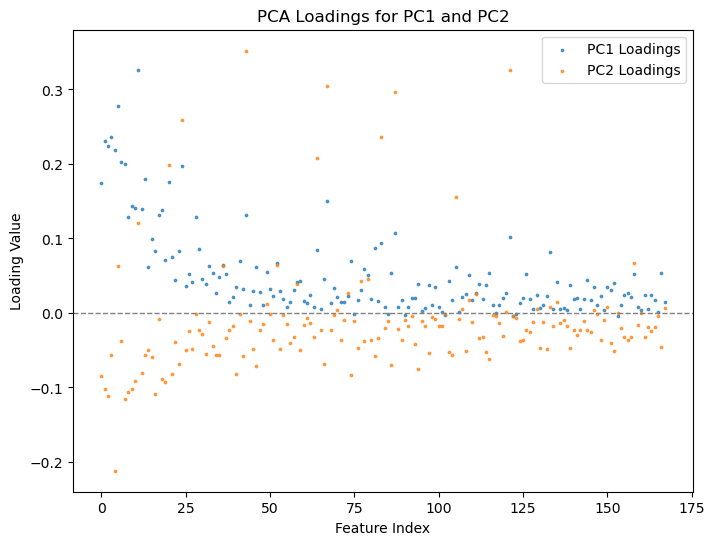

In [83]:
loadings = pca.components_

# Extract PC1 and PC2 weights
pc1_loadings = loadings[0]
pc2_loadings = loadings[1]
#pc3_loadings = loadings[2]

# Feature indices for plotting
feature_indices = np.arange(168)

# Plot PC1 weights
plt.figure(figsize=(8, 6))
plt.scatter(feature_indices, pc1_loadings, alpha=0.7, label="PC1 Loadings",s=3)
plt.scatter(feature_indices, pc2_loadings, alpha=0.7, label="PC2 Loadings", s=3)
#plt.scatter(feature_indices, pc3_loadings, alpha=0.7, label="PC3 Loadings", s=2)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Feature Index")
plt.ylabel("Loading Value")
plt.title("PCA Loadings for PC1 and PC2")
plt.legend()
plt.savefig('PC1_2_loadings.pdf')
plt.show()

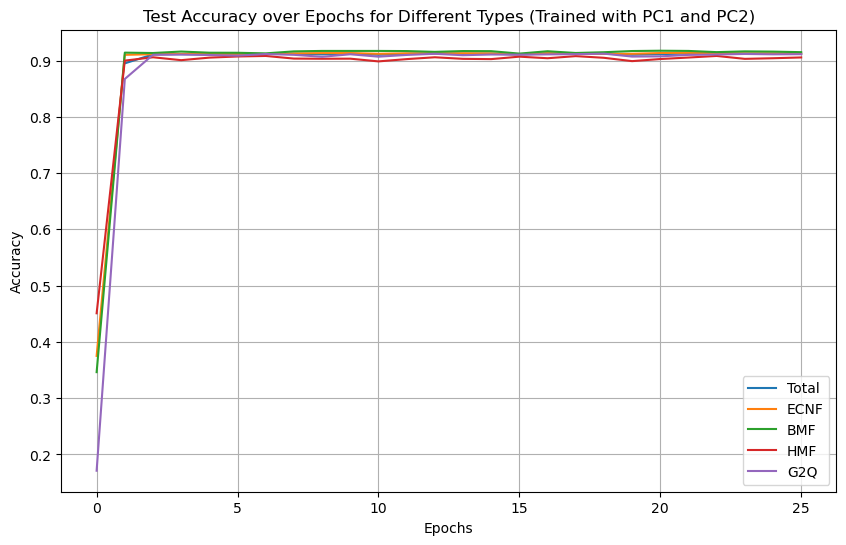

In [82]:
# Plotting train and test accuracy
plt.figure(figsize=(10, 6))
i = 0
plt.plot(range(1, epochs+1), test_accuracy_list[i], label='Total')
for instance_type in possible_instance_types:
    plt.plot(range(0, epochs+1), test_accuracies_type[instance_type], label=f'{instance_type}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs for Different Types (Trained with PC1 and PC2)')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve_PC1_2.pdf')
plt.show()

In [19]:
for instance_type in possible_instance_types:
    print(instance_type, f'{test_accuracies_type[instance_type][-1]:.4f}')

ECNF 0.9128
BMF 0.9170
HMF 0.9016
G2Q 0.9099


In [20]:
def print_output_shape(module, input, output):
    print(f"{module.__class__.__name__}: {output.shape}")

# Register hooks for each layer
for layer in model.modules():
    if isinstance(layer, (nn.Conv1d, nn.Linear)):  # Choose which layers you want
        layer.register_forward_hook(print_output_shape)

In [21]:
output = model(input_data.to(device))

Conv1d: torch.Size([3000, 16, 2])
Conv1d: torch.Size([3000, 32, 2])
Conv1d: torch.Size([3000, 64, 2])
Linear: torch.Size([3000, 128])
Linear: torch.Size([3000, 128])
Linear: torch.Size([3000, 4])
